In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# DATA PREPROCESSING

In [2]:
data_path = "/Users/piotrrylko/active_learning/Base.csv"
df = pd.read_csv(data_path)

encoder = OneHotEncoder(sparse=False)
categorical_variables = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
encoded_data = encoder.fit_transform(df[categorical_variables])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_variables))

df = df.drop(['device_fraud_count', 'month'], axis=1)
df = df.drop(categorical_variables, axis=1)
df = pd.concat([df, encoded_df], axis=1)

numerical_columns = ['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes']
df[numerical_columns] = df[numerical_columns].replace(-1, np.nan)
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())

X = df.drop('fraud_bool', axis=1) # replace with your features
y = df['fraud_bool'] # replace with your target variable

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# LOGISTIC REGRESSION

In [3]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:,1]  

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_test_prob)
print("\nAUC-ROC:", auc)

# Find top 4000 data points with highest prediction probabilities (2% of test data so that corresponds to our steered claims)
top2percent_indices = np.argsort(y_test_prob)[::-1][:int(len(y_test) * 0.02)]
top2percent_true_labels = y_test.reset_index(drop=True)[top2percent_indices]
num_actually_fraud = (top2percent_true_labels == 1).sum()
print("\nNumber of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud)
print("\nProportion of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud / len(top2percent_indices))
print("\nBest possible proportion: ", y_test.sum() / len(top2percent_indices))
print("\ntop2percent recall: ", num_actually_fraud / y_test.sum())

Confusion Matrix:
[[158942  38852]
 [   458   1748]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    197794
           1       0.04      0.79      0.08      2206

    accuracy                           0.80    200000
   macro avg       0.52      0.80      0.49    200000
weighted avg       0.99      0.80      0.88    200000


AUC-ROC: 0.8730952519618684

Number of actual frauds among top2percent datapoints with highest prediction:  643

Proportion of actual frauds among top2percent datapoints with highest prediction:  0.16075

Best possible proportion:  0.5515

top2percent recall:  0.2914777878513146


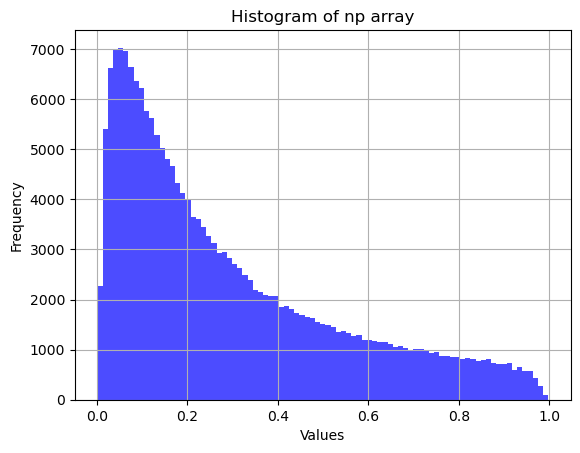

In [4]:
# plt.hist(y_test_prob * (y_test.sum() / len(y_test) / y_test_prob.mean()), bins='auto', alpha=0.7, color='blue')
plt.hist(y_test_prob, bins='auto', alpha=0.7, color='blue')
plt.title('Histogram of np array')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

/var/folders/vt/2kwrz5sx6lv4pbrrqm9spw540000gn/T/ipykernel_24847/4250756715.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test_prob_iso, shade=True, color='blue')


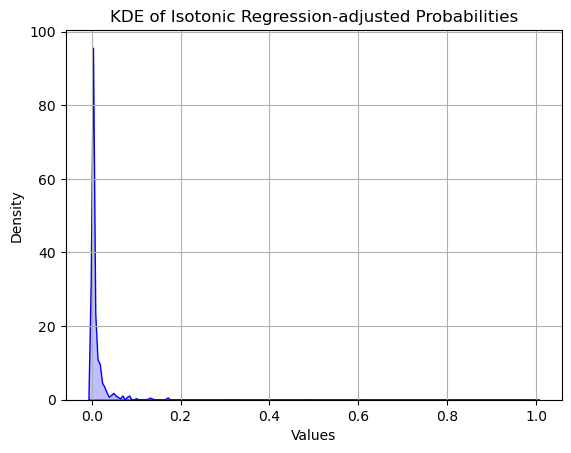

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
import seaborn as sns

# Sample data (replace with your actual data)
# y_test_prob = np.random.rand(100)  # Replace with actual prediction probabilities
# y_test = np.random.randint(0, 2, size=100)  # Replace with actual true binary labels

# Apply Isotonic Regression
iso_reg = IsotonicRegression()
y_test_prob_iso = iso_reg.fit_transform(y_test_prob, y_test)

# Plot the smooth distribution using KDE
sns.kdeplot(y_test_prob_iso, shade=True, color='blue')
plt.title('KDE of Isotonic Regression-adjusted Probabilities')
plt.xlabel('Values')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [8]:
feature_names = X_train.columns
log_reg_coefs = model.coef_[0]

df_coefs = pd.DataFrame({
    'Variable': feature_names, 
    'Logistic Model Coefficient': log_reg_coefs
})

df_coefs.sort_values('Logistic Model Coefficient')

,Variable,Logistic Model Coefficient
18,has_other_cards,-0.522426
15,phone_home_valid,-0.464793
22,keep_alive_session,-0.360963
1,name_email_similarity,-0.346157
45,device_os_linux,-0.244311
40,housing_status_BE,-0.156369
12,date_of_birth_distinct_emails_4w,-0.135842
34,employment_status_CF,-0.132994
47,device_os_other,-0.110139
6,intended_balcon_amount,-0.103783


# REGULARSIED LOGISTIC REGRESSION

In [7]:
param_grid = dict(C=np.logspace(-1, 3, 5), penalty=['l2'])
model = LogisticRegression(solver='liblinear')
grid_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=3)
grid_model.fit(X_train, y_train)

print('Best C:', grid_model.best_estimator_.get_params()['C'])
print("Best cross-validation score (AUC-ROC): ", grid_model.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .................C=0.1, penalty=l2;, score=0.870 total time=   1.5s
[CV 2/3] END .................C=0.1, penalty=l2;, score=0.872 total time=   1.9s
[CV 3/3] END .................C=0.1, penalty=l2;, score=0.872 total time=   2.0s
[CV 1/3] END .................C=1.0, penalty=l2;, score=0.870 total time=   1.5s
[CV 2/3] END .................C=1.0, penalty=l2;, score=0.871 total time=   2.0s
[CV 3/3] END .................C=1.0, penalty=l2;, score=0.872 total time=   2.0s
[CV 1/3] END ................C=10.0, penalty=l2;, score=0.870 total time=   1.5s
[CV 2/3] END ................C=10.0, penalty=l2;, score=0.871 total time=   2.5s
[CV 3/3] END ................C=10.0, penalty=l2;, score=0.872 total time=   2.4s
[CV 1/3] END ...............C=100.0, penalty=l2;, score=0.870 total time=   1.6s
[CV 2/3] END ...............C=100.0, penalty=l2;, score=0.871 total time=   2.5s
[CV 3/3] END ...............C=100.0, penalty=l2;,

In [8]:
model_best = grid_model.best_estimator_
y_pred = model_best.predict(X_test)
y_test_prob = model_best.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_test_prob)
print("\nAUC-ROC:", auc)

# Find top 4000 data points with highest prediction probabilities (2% of test data so that corresponds to our steered claims)
top2percent_indices = np.argsort(y_test_prob)[::-1][:int(len(y_test) * 0.02)]
top2percent_true_labels = y_test.reset_index(drop=True)[top2percent_indices]
num_actually_fraud = (top2percent_true_labels == 1).sum()
print("\nNumber of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud)
print("\nProportion of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud / len(top2percent_indices))
print("\nBest possible proportion: ", y_test.sum() / len(top2percent_indices))
print("\ntop2percent recall: ", num_actually_fraud / y_test.sum())

Confusion Matrix:
[[197777     17]
 [  2181     25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197794
           1       0.60      0.01      0.02      2206

    accuracy                           0.99    200000
   macro avg       0.79      0.51      0.51    200000
weighted avg       0.98      0.99      0.98    200000


AUC-ROC: 0.871966904200842

Number of actual frauds among top2percent datapoints with highest prediction:  652

Proportion of actual frauds among top2percent datapoints with highest prediction:  0.163

Best possible proportion:  0.5515

top2percent recall:  0.2955575702629193


# RANDOM FOREST

In [9]:
param_grid = {
    'n_estimators': [500],
    'max_depth' : [16],
    'min_samples_split': [100],
    'min_samples_leaf': [80] 
}

rf = RandomForestClassifier()
CV_rf = RandomizedSearchCV(n_iter=18, estimator=rf, param_distributions=param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=3)
CV_rf.fit(X_train, y_train)
print("Best parameters (CV score=%0.3f):" % CV_rf.best_score_)
print(CV_rf.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=18. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 3/3] END max_depth=16, min_samples_leaf=80, min_samples_split=100, n_estimators=500;, score=0.881 total time= 7.0min
[CV 2/3] END max_depth=16, min_samples_leaf=80, min_samples_split=100, n_estimators=500;, score=0.880 total time= 7.1min
[CV 1/3] END max_depth=16, min_samples_leaf=80, min_samples_split=100, n_estimators=500;, score=0.880 total time= 7.1min
Best parameters (CV score=0.880):
{'n_estimators': 500, 'min_samples_split': 100, 'min_samples_leaf': 80, 'max_depth': 16}


In [10]:
y_pred = CV_rf.best_estimator_.predict(X_test)
y_test_prob = CV_rf.best_estimator_.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_test_prob)
print("\nAUC-ROC:", auc)

# Find top 4000 data points with highest prediction probabilities (2% of test data so that corresponds to our steered claims)
top2percent_indices = np.argsort(y_test_prob)[::-1][:int(len(y_test) * 0.02)]
top2percent_true_labels = y_test.reset_index(drop=True)[top2percent_indices]
num_actually_fraud = (top2percent_true_labels == 1).sum()
print("\nNumber of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud)
print("\nProportion of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud / len(top2percent_indices))
print("\nBest possible proportion: ", y_test.sum() / len(top2percent_indices))
print("\ntop2percent recall: ", num_actually_fraud / y_test.sum())

Confusion Matrix:
[[197794      0]
 [  2206      0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197794
           1       0.00      0.00      0.00      2206

    accuracy                           0.99    200000
   macro avg       0.49      0.50      0.50    200000
weighted avg       0.98      0.99      0.98    200000


AUC-ROC: 0.8832066400466045

Number of actual frauds among top2percent datapoints with highest prediction:  707

Proportion of actual frauds among top2percent datapoints with highest prediction:  0.17675

Best possible proportion:  0.5515

top2percent recall:  0.3204895738893926


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [231]:
df = pd.DataFrame(CV_rf.cv_results_)
df_results = df[['mean_test_score', 'std_test_score', 'rank_test_score']]
params_df = pd.DataFrame(df['params'].tolist())
df_results = pd.concat([df_results, params_df], axis=1)
df_results = df_results.sort_values(by=["mean_test_score"], ascending=False)
df_results.reset_index(drop=True, inplace=True)
df_results

,mean_test_score,std_test_score,rank_test_score,n_estimators,min_samples_split,min_samples_leaf,max_depth
0,0.880347,0.000270,1,500,100,80,16
1,0.879963,0.000578,2,500,100,40,16
2,0.879458,0.000272,3,500,100,40,14
3,0.879400,0.000610,4,500,100,160,14
4,0.879336,0.000389,5,500,100,80,14
5,0.879328,0.000533,6,500,100,160,16
6,0.878377,0.000225,7,500,100,80,12
7,0.878003,0.000485,8,500,100,40,12
8,0.877971,0.000336,9,500,100,160,12


In [209]:
model_best_params = RandomForestClassifier(n_estimators=CV_rf.best_params_['n_estimators'], 
                                           max_depth=CV_rf.best_params_['max_depth'], 
                                           min_samples_split=CV_rf.best_params_['min_samples_split'], 
                                           min_samples_leaf=CV_rf.best_params_['min_samples_leaf'],
                                           class_weight='balanced')
model_best_params.fit(X_train, y_train)

y_pred = model_best_params.predict(X_test)
y_test_prob = model_best_params.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_test_prob)
print("\nAUC-ROC:", auc)

# Find top 4000 data points with highest prediction probabilities (2% of test data so that corresponds to our steered claims)
top2percent_indices = np.argsort(y_test_prob)[::-1][:int(len(y_test) * 0.02)]
top2percent_true_labels = y_test.reset_index(drop=True)[top2percent_indices]
num_actually_fraud = (top2percent_true_labels == 1).sum()
print("\nNumber of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud)
print("\nProportion of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud / len(top2percent_indices))

Confusion Matrix:
[[197792      2]
 [  2205      1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197794
           1       0.33      0.00      0.00      2206

    accuracy                           0.99    200000
   macro avg       0.66      0.50      0.50    200000
weighted avg       0.98      0.99      0.98    200000


AUC-ROC: 0.8258420489055021

Number of actual frauds among top2percent datapoints with highest prediction:  613

Proportion of actual frauds among top2percent datapoints with highest prediction:  0.15325


# LIGHT GBM

In [101]:
param_grid = {
    'objective': ['binary'],
    'boosting_type': ['goss'],
    'n_estimators': [500],
    'max_depth': [16],
    'num_leaves': [63],
    'min_child_samples': [300],
    'colsample_bytree': [0.2],
    'learning_rate': [0.02]
}


lgbm = LGBMClassifier()
CV_lgbm = RandomizedSearchCV(
    n_iter=9,
    estimator=lgbm, 
    param_distributions=param_grid, 
    cv=3, 
    n_jobs=-1, 
    scoring='roc_auc',
    verbose=3
)

CV_lgbm.fit(X_train, y_train)
print("Best parameters : ", CV_lgbm.best_params_)
print("AUC - ROC : ", CV_lgbm.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=9. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 5882, number of negative: 527451
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons

In [90]:
df = pd.DataFrame(CV_lgbm.cv_results_)
df_results = df[['mean_test_score', 'std_test_score', 'rank_test_score']]
params_df = pd.DataFrame(df['params'].tolist())
df_results = pd.concat([df_results, params_df], axis=1)
df_results = df_results.sort_values(by=["mean_test_score"], ascending=False)
df_results.reset_index(drop=True, inplace=True)
df_results

,mean_test_score,std_test_score,rank_test_score,objective,num_leaves,n_estimators,min_child_samples,max_depth,learning_rate,colsample_bytree,boosting_type
0,0.898554,0.000771,1,binary,63,500,300,16,0.02,0.2,goss


In [102]:
y_pred = CV_lgbm.best_estimator_.predict(X_test)
y_test_prob = CV_lgbm.best_estimator_.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_test_prob)
print("\nAUC-ROC:", auc)

# Find top 2% data points with highest prediction probabilities
top2percent_indices = np.argsort(y_test_prob)[::-1][:int(len(y_test) * 0.02)]
top2percent_true_labels = y_test.reset_index(drop=True)[top2percent_indices]
num_actually_fraud = (top2percent_true_labels == 1).sum()
print("\nNumber of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud)
print("\nProportion of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud / len(top2percent_indices))
print("\nBest possible proportion: ", y_test.sum() / len(top2percent_indices))
print("\ntop2percent recall: ", num_actually_fraud / y_test.sum())

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Confusion Matrix:
[[197757     37]
 [  2142     64]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197794
           1       0.63      0.03      0.06      2206

    accuracy                           0.99    200000
   macro avg       0.81      0.51      0.53    200000
weighted avg       0.99      0.99      0.98    200000


AUC-ROC: 0.8987567914899162

Number of actual frauds among top2percent datapoints with highest prediction:  756

Proportion of actual frauds among top2percent datapoints

In [352]:
0.8987567914899162/ 0.871966904200842

1.0307235138856872

# LIGHT GBM (top2% tuning)

In [63]:
def top2perc_score(y_test, y_test_prob):
    top2percent_indices = np.argsort(y_test_prob)[::-1][:int(len(y_test) * 0.02)]
    top2percent_true_labels = y_test.reset_index(drop=True)[top2percent_indices]
    num_actually_fraud = (top2percent_true_labels == 1).sum()
    return num_actually_fraud

custom_scorer = make_scorer(top2perc_score, greater_is_better=True, needs_proba=True)

In [71]:
param_grid = {
    'objective': ['binary'],
    'boosting_type': ['goss'],
    'n_estimators': [500],
    'max_depth': [16],
    'num_leaves': [63],
    'min_child_samples': [300],
    'colsample_bytree': [0.2, 0.5],
    'learning_rate': [0.01, 0.02, 0.03, 0.04]
}

lgbm = LGBMClassifier()
CV_lgbm = RandomizedSearchCV(
    n_iter=9,
    estimator=lgbm, 
    param_distributions=param_grid, 
    cv=3, 
    n_jobs=-1, 
    scoring=custom_scorer,
    verbose=3
)

CV_lgbm.fit(X_train, y_train)
print("Best parameters: ", CV_lgbm.best_params_)
print("Queried Metric Score: ", CV_lgbm.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=9. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.

In [73]:
df = pd.DataFrame(CV_lgbm.cv_results_)
df_results = df[['mean_test_score', 'std_test_score', 'rank_test_score']]
params_df = pd.DataFrame(df['params'].tolist())
df_results = pd.concat([df_results, params_df], axis=1)
df_results = df_results.sort_values(by=["mean_test_score"], ascending=False)
df_results.reset_index(drop=True, inplace=True)
df_results

,mean_test_score,std_test_score,rank_test_score,objective,num_leaves,n_estimators,min_child_samples,max_depth,learning_rate,colsample_bytree,boosting_type
0,1007.666667,7.586538,1,binary,63,500,300,16,0.03,0.2,goss
1,1007.333333,11.556624,2,binary,63,500,300,16,0.02,0.2,goss
2,1007.000000,10.708252,3,binary,63,500,300,16,0.04,0.2,goss
3,1003.000000,3.265986,4,binary,63,500,300,16,0.03,0.5,goss
4,998.333333,11.897712,5,binary,63,500,300,16,0.02,0.5,goss
5,993.333333,15.107026,6,binary,63,500,300,16,0.04,0.5,goss
6,969.000000,3.559026,7,binary,63,500,300,16,0.01,0.5,goss
7,968.333333,9.741093,8,binary,63,500,300,16,0.01,0.2,goss


In [69]:
y_pred = CV_lgbm.best_estimator_.predict(X_test)
y_test_prob = CV_lgbm.best_estimator_.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_test_prob)
print("\nAUC-ROC:", auc)

# Find top 2% data points with highest prediction probabilities
top2percent_indices = np.argsort(y_test_prob)[::-1][:int(len(y_test) * 0.02)]
top2percent_true_labels = y_test.reset_index(drop=True)[top2percent_indices]
num_actually_fraud = (top2percent_true_labels == 1).sum()
print("\nNumber of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud)
print("\nProportion of actual frauds among top2percent datapoints with highest prediction: ", num_actually_fraud / len(top2percent_indices))
print("\nBest possible proportion: ", y_test.sum() / len(top2percent_indices))
print("\ntop2percent recall: ", num_actually_fraud / y_test.sum())

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Confusion Matrix:
[[167220  30574]
 [   470   1736]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    197794
           1       0.05      0.79      0.10      2206

    accuracy                           0.84    200000
   macro avg       0.53      0.82      0.51    200000
weighted avg       0.99      0.84      0.91    200000


AUC-ROC: 0.8976685300331375

Number of actual frauds among top2percent datapoints with highest prediction:  750

Proportion of actual frauds among top2percent datapoints

In [33]:
np.random.seed(42)

# Generate synthetic data (replace this with your actual data)
# Example: X, y = your_data_function()

# Global variables
num_iterations = 100

def add_noise(X, noisy_columns):
    X_noisy = X.copy()
    filtered_columns = [col for col in X.columns if col not in noisy_columns]
    for col in filtered_columns:
        noise = np.random.normal(0, 1, X_noisy[col].shape)
        X_noisy[col] = noise
    return X_noisy

def initial_model_train(X_train, y_train, noisy_columns):
    X_train_noisy = add_noise(X_train, noisy_columns)
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train_noisy, y_train)
    return model

def initial_evaluation(model, X_test, y_test):
    y_test_prob = model.predict_proba(X_test)[:, 1]
    top_indices = np.argsort(y_test_prob)[::-1][:int(len(y_test) * 0.02)]
    top_indices = y_test.iloc[top_indices].index
    top_true_labels = y_test.loc[top_indices]
    num_actually_fraud = (top_true_labels == 1).sum()
    fraud_ratio = num_actually_fraud / len(top_indices)
    return fraud_ratio

def perform_experiment(method, method_name, num_experiments=10, top_fraction=0.02):
    all_fraud_ratios = np.zeros((num_experiments, num_iterations + 1))
    noisy_columns = ["has_other_cards", "phone_home_valid", "keep_alive_session", "housing_status_BA", "device_os_windows", "name_email_similarity"]

    for exp in range(num_experiments):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        model = initial_model_train(X_train, y_train, noisy_columns)

        y_train_prob = model.predict_proba(X_train)[:, 1]
        top_indices = np.argsort(y_train_prob)[::-1][:int(len(y_train_prob) * 0.0025)]
        top_indices = y_train.iloc[top_indices].index

        X_train_labelled = X_train.loc[top_indices]
        y_train_labelled = y_train.loc[top_indices]
        X_train_unlabelled = X_train.drop(top_indices)
        y_train_unlabelled = y_train.drop(top_indices)

        fraud_ratio = initial_evaluation(model, X_test, y_test)
        all_fraud_ratios[exp, 0] = fraud_ratio

        for i in range(num_iterations):
            model.fit(X_train_labelled, y_train_labelled)
            X_train_labelled, y_train_labelled, X_train_unlabelled, y_train_unlabelled = method(model, X_train_labelled, y_train_labelled, X_train_unlabelled, y_train_unlabelled)
            fraud_ratio = initial_evaluation(model, X_test, y_test)
            all_fraud_ratios[exp, i + 1] = fraud_ratio

    average_fraud_ratios = np.mean(all_fraud_ratios, axis=0)
    return average_fraud_ratios

# Define methods for different sampling techniques
def highest_predictions(model, X_train_labelled, y_train_labelled, X_train_unlabelled, y_train_unlabelled):
    y_unlabelled_prob = model.predict_proba(X_train_unlabelled)[:, 1]
    highest_indices = np.argsort(y_unlabelled_prob)[-100:]
    X_train_labelled = pd.concat([X_train_labelled, X_train_unlabelled.iloc[highest_indices]])
    y_train_labelled = pd.concat([y_train_labelled, y_train_unlabelled.iloc[highest_indices]])
    X_train_unlabelled = X_train_unlabelled.drop(X_train_unlabelled.index[highest_indices])
    y_train_unlabelled = y_train_unlabelled.drop(y_train_unlabelled.index[highest_indices])
    return X_train_labelled, y_train_labelled, X_train_unlabelled, y_train_unlabelled

def uncertainty_sampling(model, X_train_labelled, y_train_labelled, X_train_unlabelled, y_train_unlabelled):
    y_unlabelled_prob = model.predict_proba(X_train_unlabelled)[:, 1]
    uncertainty = np.abs(y_unlabelled_prob - 0.5)
    uncertain_indices = np.argsort(uncertainty)[:100]
    X_train_labelled = pd.concat([X_train_labelled, X_train_unlabelled.iloc[uncertain_indices]])
    y_train_labelled = pd.concat([y_train_labelled, y_train_unlabelled.iloc[uncertain_indices]])
    X_train_unlabelled = X_train_unlabelled.drop(X_train_unlabelled.index[uncertain_indices])
    y_train_unlabelled = y_train_unlabelled.drop(y_train_unlabelled.index[uncertain_indices])
    return X_train_labelled, y_train_labelled, X_train_unlabelled, y_train_unlabelled

def random_sampling(model, X_train_labelled, y_train_labelled, X_train_unlabelled, y_train_unlabelled):
    random_indices = np.random.choice(X_train_unlabelled.index, size=100, replace=False)
    X_train_labelled = pd.concat([X_train_labelled, X_train_unlabelled.loc[random_indices]])
    y_train_labelled = pd.concat([y_train_labelled, y_train_unlabelled.loc[random_indices]])
    X_train_unlabelled = X_train_unlabelled.drop(random_indices)
    y_train_unlabelled = y_train_unlabelled.drop(random_indices)
    return X_train_labelled, y_train_labelled, X_train_unlabelled, y_train_unlabelled

def around_0_98_quantile(model, X_train_labelled, y_train_labelled, X_train_unlabelled, y_train_unlabelled):
    y_unlabelled_prob = model.predict_proba(X_train_unlabelled)[:, 1]
    quantile_index = int(0.98 * len(y_unlabelled_prob))
    sorted_indices = np.argsort(y_unlabelled_prob)
    target_index = sorted_indices[quantile_index]
    around_quantile_indices = sorted_indices[max(0, quantile_index-50):min(len(sorted_indices), quantile_index+50)]
    X_train_labelled = pd.concat([X_train_labelled, X_train_unlabelled.iloc[around_quantile_indices]])
    y_train_labelled = pd.concat([y_train_labelled, y_train_unlabelled.iloc[around_quantile_indices]])
    X_train_unlabelled = X_train_unlabelled.drop(X_train_unlabelled.index[around_quantile_indices])
    y_train_unlabelled = y_train_unlabelled.drop(y_train_unlabelled.index[around_quantile_indices])
    return X_train_labelled, y_train_labelled, X_train_unlabelled, y_train_unlabelled


In [34]:
average_fraud_ratios_HIGHEST = perform_experiment(highest_predictions, 'Highest Predictions')


Highest Predictions Method:   0%|          | 0/10 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

In [35]:
average_fraud_ratios_UNCERTAINTY = perform_experiment(uncertainty_sampling, 'Uncertainty Sampling')


Uncertainty Sampling Method:   0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [36]:
average_fraud_ratios_RANDOM = perform_experiment(random_sampling, 'Random Sampling')


Random Sampling Method:   0%|          | 0/10 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

In [37]:
average_fraud_ratios_AROUND_0_98_QUANTILE = perform_experiment(around_0_98_quantile, 'Around 0.98 Quantile')


Around 0.98 Quantile Method:   0%|          | 0/10 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

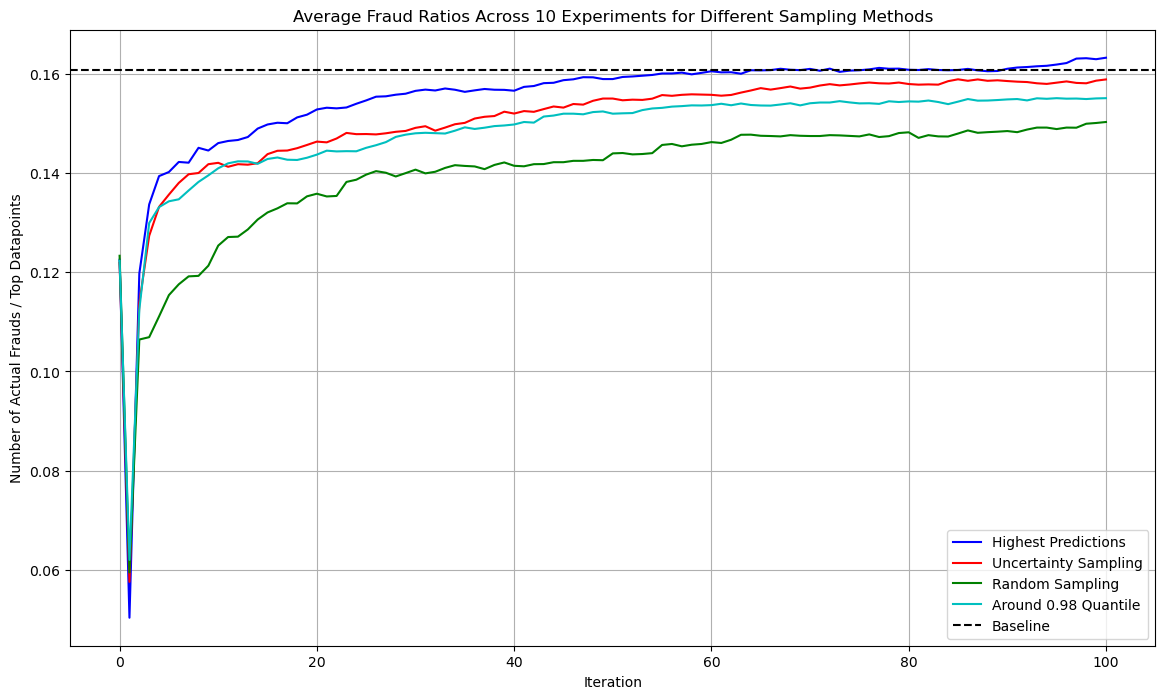

In [38]:
plt.figure(figsize=(14, 8))
plt.plot(range(num_iterations + 1), average_fraud_ratios_HIGHEST, label='Highest Predictions', color='b')
plt.plot(range(num_iterations + 1), average_fraud_ratios_UNCERTAINTY, label='Uncertainty Sampling', color='r')
plt.plot(range(num_iterations + 1), average_fraud_ratios_RANDOM, label='Random Sampling', color='g')
plt.plot(range(num_iterations + 1), average_fraud_ratios_AROUND_0_98_QUANTILE, label='Around 0.98 Quantile', color='c')
plt.axhline(y=0.16075, color='k', linestyle='--', label='Baseline')
plt.xlabel('Iteration')
plt.ylabel('Number of Actual Frauds / Top Datapoints')
plt.title('Average Fraud Ratios Across 10 Experiments for Different Sampling Methods')
plt.grid(True)
plt.legend()
plt.show()


# BELOW NOT NECESSARY FOR THE RESULTS
### this was my analysis and all is already combined above


# UNCERTAINTY

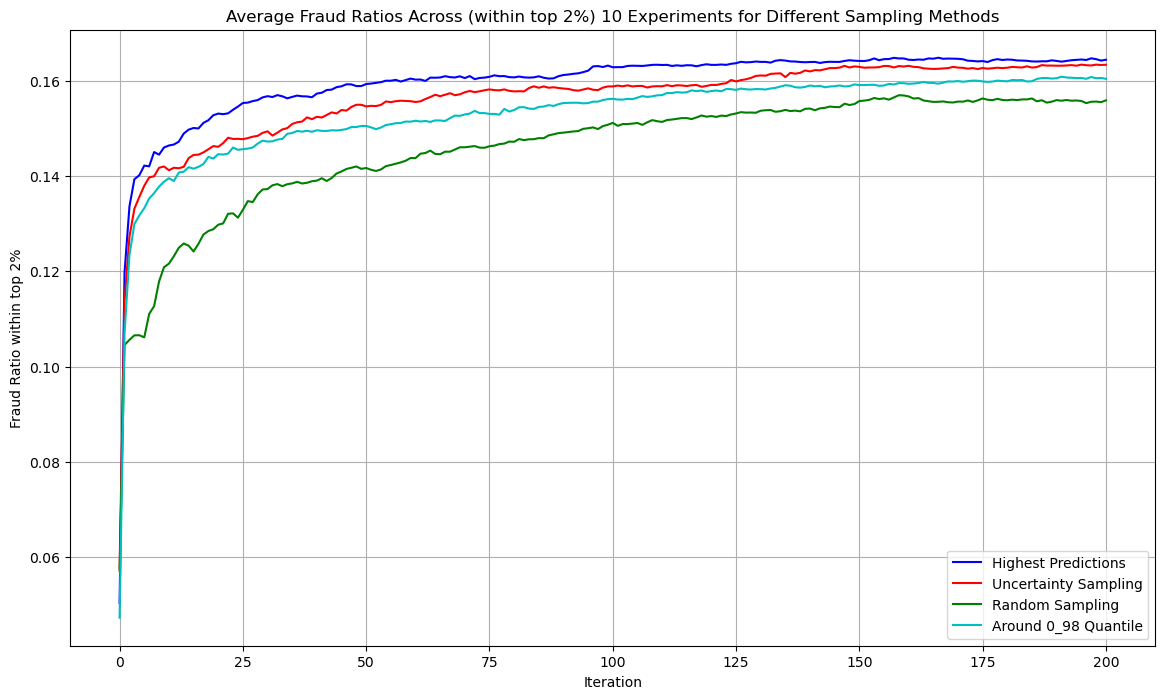

In [123]:
# Plotting the average fraud ratios for all four methods
plt.figure(figsize=(14, 8))
plt.plot(range(201), average_fraud_ratios_HIGHEST, label='Highest Predictions', color='b')  # Changed from 301 to 201
plt.plot(range(201), average_fraud_ratios_UNCERTAINTY, label='Uncertainty Sampling', color='r')  # Changed from 301 to 201
plt.plot(range(201), average_fraud_ratios_RANDOM, label='Random Sampling', color='g')  # Changed from 301 to 201
plt.plot(range(201), average_fraud_ratios_AROUND_0_98_QUANTILE, label='Around 0_98 Quantile', color='c')  # Changed from 301 to 201
plt.xlabel('Iteration')
plt.ylabel('Fraud Ratio within top 2%')
plt.title('Average Fraud Ratios Across (within top 2%) 10 Experiments for Different Sampling Methods')
plt.grid(True)
plt.legend()
plt.show()

# ISOLATION FOREST

In [326]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [327]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.001, random_state=42)
iso_forest.fit(X_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.001, random_state=42)

In [335]:
preds = iso_forest.predict(X_test)
y_pred = np.where(preds == -1, 1, 0)

In [336]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[197609    185]
 [  2203      3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197794
           1       0.02      0.00      0.00      2206

    accuracy                           0.99    200000
   macro avg       0.50      0.50      0.50    200000
weighted avg       0.98      0.99      0.98    200000

